In [2]:
# !tar -xzvf ../data/ThirtyMusic.tar.gz

x entities/
x entities/users.idomaar
x entities/playlist.idomaar
x entities/tracks.idomaar
x entities/tags.idomaar
x entities/persons.idomaar
x entities/albums.idomaar
x relations/
x relations/events.idomaar
x relations/sessions.idomaar
x relations/love.idomaar


# Import

In [1]:
# import ast
import json
import pandas as pd
# from pprint import pprint

# Чтение файлов

In [124]:
%%time
# исполнители
persons = pd.read_table(
    '../data/entities/persons.idomaar',
    header=None,
    # nrows=10000,
    names=[
        'type',
        'person_id',
        'timestamp',
        'properties',
        'linked-entities'
    ]
)
# парсим json
persons['properties'] = persons['properties'].apply(json.loads)
persons['person_name'] = persons['properties'].apply(lambda dct: dct['name'])
persons['person_MBID'] = persons['properties'].apply(lambda dct: dct['MBID'])
# выбросим лишнее
persons = persons.drop(columns=[
    'type', # содержит только 'person'
    'timestamp', # содержит только # -1
    'linked-entities', # содержит только '{}',
    'properties' # распарсили ранее
])


# треки
tracks = pd.read_table(
    '../data/entities/tracks.idomaar',
    header=None,
    nrows=100000,
    names=[
        'type',
        'track_id',
        'timestamp',
        'properties',
        'linked-entities'
    ]
)
# парсим json
tracks['properties'] = tracks['properties'].apply(json.loads)
tracks['linked-entities'] = tracks['linked-entities'].apply(json.loads)
# # достанем значения из 'properties'
# tracks['track_name'] = tracks['properties'].apply(lambda dct: dct['name'])
# tracks['track_MBID'] = tracks['properties'].apply(lambda dct: dct['MBID'])
# tracks['duration'] = tracks['properties'].apply(lambda dct: dct['duration'])
tracks['playcount'] = tracks['properties'].apply(lambda dct: dct['playcount'])
# # достанем значения из 'linked-entities'
# tracks['tags'] = tracks['linked-entities'].apply(lambda dct: dct['tags'])
# tracks['albums'] = tracks['linked-entities'].apply(lambda dct: dct['albums'])
tracks['person_id'] = tracks['linked-entities'].apply(lambda dct: dct['artists'][0]['id'])
# выбросим лишнее
tracks = tracks.drop(columns=[
    'type', # содержит только 'tracks'
    'timestamp', # содержит только # -1
    'linked-entities', # распарсили ранее
    'properties' # распарсили ранее
])


# сессии с прослушиванием
sessions = pd.read_table(
    '../data/relations/sessions.idomaar',
    header=None,
    nrows=100000,
    names=['type', 'session_id', 'timestamp', 'properties']
)
# парсим json
sessions[['statistics', 'subjects']] = sessions['properties'].str.split(' ', 1, expand=True)
sessions['subjects'] = sessions['subjects'].apply(json.loads)
sessions['statistics'] = sessions['statistics'].apply(json.loads)
# достанем значения из 'statistics'
sessions['playtime'] = sessions['statistics'].apply(lambda dct: dct['playtime'])
sessions['numtracks'] = sessions['statistics'].apply(lambda dct: dct['numtracks'])
# достанем значения из 'subjects'
sessions['user_id'] = sessions['subjects'].apply(lambda dct: dct['subjects'][0]['id'])
sessions['objects'] = sessions['subjects'].apply(lambda dct: dct['objects'])
# тк в 'objects' хранится список словарей, где каждый словарь, это песня из сессии
# то разносим каждый такой словарь в отдельную строку
sessions = sessions.explode('objects')
# достанем значения из 'objects'
# также есть ('type' (содержит 'track'), 'playstart', 'playtime', 'playratio', 'action')
sessions['track_id'] = sessions['objects'].apply(lambda dct: dct['id'])
sessions['track_playratio'] = sessions['objects'].apply(lambda dct: dct['playratio'])
# выбросим лишнее
sessions = sessions.drop(columns=[
    'type', # содержит только 'event.session'
    'properties', # распарсили ранее
    'statistics', # распарсили ранее
    'subjects', # распарсили ранее
    'objects' # распарсили ранее
])

CPU times: user 20 s, sys: 2.32 s, total: 22.3 s
Wall time: 27 s


In [125]:
print(persons.shape)
persons.head()

(595049, 3)


,person_id,person_name,person_MBID
0,145148,Everything+Is+Illuminated,None
1,297899,Robin+O%27Brien,None
2,250429,Nicholas+Gunn++(2012),None
3,32765,Aspasia+Stratigou,None
4,18689,Allison+Veltz,None


In [163]:
# sessions.drop_duplicates()

In [126]:
print(tracks.shape)
tracks.head()

(100000, 3)


,track_id,playcount,person_id
0,0,4,0
1,1,495,1
2,2,2,2
3,3,2,3
4,4,1,4


In [127]:
print(sessions.shape)
sessions.head()

(1133344, 7)


,session_id,timestamp,playtime,numtracks,user_id,track_id,track_playratio
0,287144,1390231051,4547,23,44361,4698874,NaN
0,287144,1390231051,4547,23,44361,838286,1.01
0,287144,1390231051,4547,23,44361,2588097,1.01
0,287144,1390231051,4547,23,44361,2746740,1.44
0,287144,1390231051,4547,23,44361,3873988,1.01


In [128]:
# sessions['track_playratio'].describe()

# Переход к истории прослушивания исполнителей

In [129]:
sessions_extend = (sessions
    # переход от истории прослушиваний треков к истории прослушивания исполнителей
    .merge(
        tracks,
        how='inner',
        on=['track_id']
    )
    # дополнительная информация по исполнителям
    .merge(
        persons,
        how='inner',
        on=['person_id']
    )
)

In [130]:
sessions_extend

,session_id,timestamp,playtime,numtracks,user_id,track_id,track_playratio,playcount,person_id,person_name,person_MBID
0,778286,1396356280,1372,9,13270,93163,1.02,358,12631,Agrot%C3%B3xico,9665a711-de65-4d95-a8cf-06076a4f9815
1,778282,1390710507,9438,66,13270,93165,1.01,375,12631,Agrot%C3%B3xico,9665a711-de65-4d95-a8cf-06076a4f9815
2,778283,1390776011,14200,99,13270,93185,1.00,2078,12631,Agrot%C3%B3xico,9665a711-de65-4d95-a8cf-06076a4f9815
3,778283,1390776011,14200,99,13270,93186,1.01,450,12631,Agrot%C3%B3xico,9665a711-de65-4d95-a8cf-06076a4f9815
4,766932,1410198786,4680,30,8605,93181,0.71,2059,12631,Agrot%C3%B3xico,9665a711-de65-4d95-a8cf-06076a4f9815
...,...,...,...,...,...,...,...,...,...,...,...
155713,2745122,1421201376,3662,23,35387,95988,1.00,156,12940,Ahwlee,813939fd-298a-4f14-a646-f7475004467a
155714,2745122,1421201376,3662,23,35387,95983,1.01,46,12940,Ahwlee,813939fd-298a-4f14-a646-f7475004467a
155715,2745122,1421201376,3662,23,35387,95967,1.00,43,12940,Ahwlee,813939fd-298a-4f14-a646-f7475004467a
155716,2745122,1421201376,3662,23,35387,95996,1.00,31,12940,Ahwlee,813939fd-298a-4f14-a646-f7475004467a


## Посмотрим на данные

(0, 300)

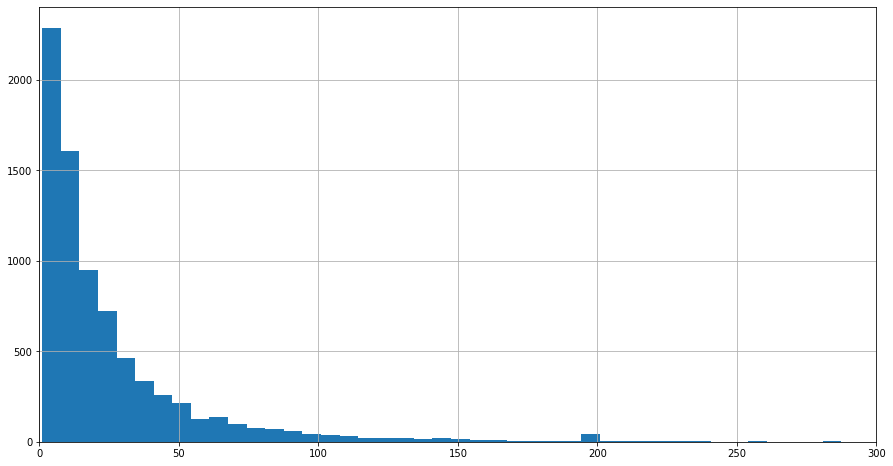

In [114]:
numtracks_in_sessions = sessions_extend[['session_id', 'numtracks']].drop_duplicates()
hist = numtracks_in_sessions['numtracks'].hist(bins=150, figsize=(15, 8))
hist.set_xlim(0, 300)

In [158]:
numtracks_in_sessions['numtracks'].describe(percentiles=[
    0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.9725
])

count    7761.000000
mean       26.665249
std        39.773671
min         1.000000
2.5%        1.000000
5%          1.000000
25%         6.000000
50%        14.000000
75%        31.000000
95%        91.000000
97.2%     127.000000
max      1000.000000
Name: numtracks, dtype: float64

(0, 40000)

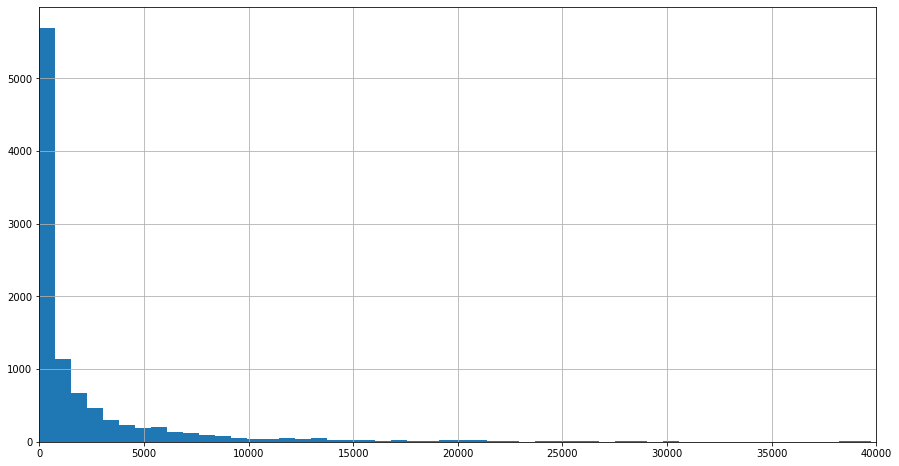

In [142]:
track_playcount = sessions_extend[['track_id', 'playcount', 'person_id']].drop_duplicates()
hist = track_playcount['playcount'].hist(bins=150, figsize=(15, 8))
hist.set_xlim(0, 40000)

In [157]:
track_playcount['playcount'].describe(percentiles=[
    0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.9725
])

count      9939.000000
mean       2346.222859
std        5558.030150
min           0.000000
2.5%          1.000000
5%            2.000000
25%          42.000000
50%         433.000000
75%        2227.500000
95%       10912.000000
97.2%     15506.920000
max      114678.000000
Name: playcount, dtype: float64

(0, 25000)

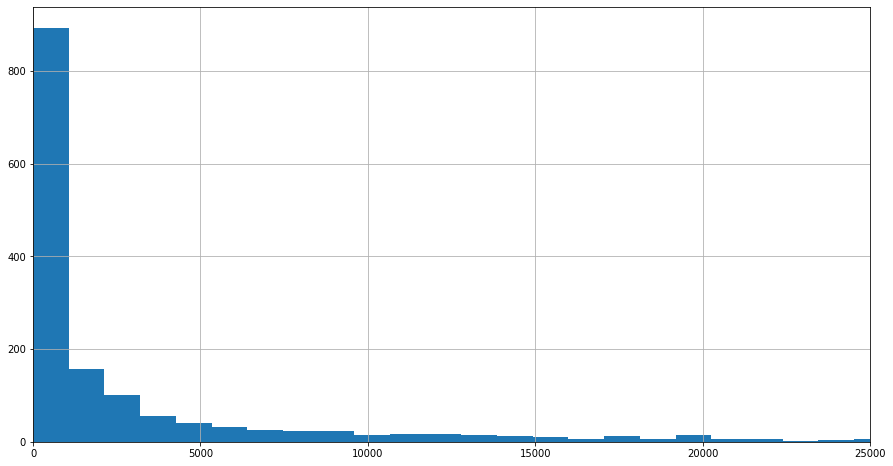

In [153]:
person_playcount = (sessions_extend[['track_id', 'playcount', 'person_id']]
    .drop_duplicates()
    .groupby(['person_id'], as_index=False)['playcount']
    .sum()
)
hist = person_playcount['playcount'].hist(bins=2000, figsize=(15, 8))
hist.set_xlim(0, 25000)

In [156]:
# person_playcount
person_playcount['playcount'].describe(percentiles=[
    0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.9725
])

count    1.668000e+03
mean     1.398028e+04
std      5.505446e+04
min      0.000000e+00
2.5%     1.000000e+00
5%       2.000000e+00
25%      7.100000e+01
50%      8.055000e+02
75%      5.437750e+03
95%      5.833740e+04
97.2%    1.311756e+05
max      1.066022e+06
Name: playcount, dtype: float64

In [159]:
sessions_extend

,session_id,timestamp,playtime,numtracks,user_id,track_id,track_playratio,playcount,person_id,person_name,person_MBID
0,778286,1396356280,1372,9,13270,93163,1.02,358,12631,Agrot%C3%B3xico,9665a711-de65-4d95-a8cf-06076a4f9815
1,778282,1390710507,9438,66,13270,93165,1.01,375,12631,Agrot%C3%B3xico,9665a711-de65-4d95-a8cf-06076a4f9815
2,778283,1390776011,14200,99,13270,93185,1.00,2078,12631,Agrot%C3%B3xico,9665a711-de65-4d95-a8cf-06076a4f9815
3,778283,1390776011,14200,99,13270,93186,1.01,450,12631,Agrot%C3%B3xico,9665a711-de65-4d95-a8cf-06076a4f9815
4,766932,1410198786,4680,30,8605,93181,0.71,2059,12631,Agrot%C3%B3xico,9665a711-de65-4d95-a8cf-06076a4f9815
...,...,...,...,...,...,...,...,...,...,...,...
155713,2745122,1421201376,3662,23,35387,95988,1.00,156,12940,Ahwlee,813939fd-298a-4f14-a646-f7475004467a
155714,2745122,1421201376,3662,23,35387,95983,1.01,46,12940,Ahwlee,813939fd-298a-4f14-a646-f7475004467a
155715,2745122,1421201376,3662,23,35387,95967,1.00,43,12940,Ahwlee,813939fd-298a-4f14-a646-f7475004467a
155716,2745122,1421201376,3662,23,35387,95996,1.00,31,12940,Ahwlee,813939fd-298a-4f14-a646-f7475004467a


In [ ]:
# groups = np.array([0, 0, 2, 2])
group_kfold = GroupKFold(n_splits=2)